# Create target dataset and train YOLO on Kaggle

1. Create dataset chapter was executing totally on CPU (No Accelerator)
2. Train model chapter was executing on GPU P100

Before starting add two datasets to input:
- sku110k-annotations
- target_SKU

In [ ]:
import matplotlib.pyplot as plt
import cv2

import os
import random
import numpy as np
import pandas as pd
import json
from pathlib import Path
import albumentations as A

from tqdm import tqdm
tqdm.pandas()

In [ ]:
RANDOM_STATE = 42

In [ ]:
ROOT_PATH = Path("/kaggle/input/sku110k-annotations")
DATA_PATH = ROOT_PATH / "SKU110K_fixed"
IMAGES_PATH = DATA_PATH / "images"
LABEL_PATH = DATA_PATH / "labels"

DATASET_NAME = ['test', 'train', 'val']


print(f"Images:")
for name in DATASET_NAME:
    print(f'\t{name}: {len(list(IMAGES_PATH.glob(f"{name}/*")))}')

print(f"Labels:")
for name in DATASET_NAME:
    print(f'\t{name}: {len(list(LABEL_PATH.glob(f"{name}/*")))}')


Images:
	test: 2920
	train: 8185
	val: 584
Labels:
	test: 2920
	train: 8185
	val: 584


# Create target datasets

In [ ]:
TARGET_DATA_PATH = Path('/kaggle/working/target_SKU')
TARGET_IMAGES_PATH = TARGET_DATA_PATH / "images"
TARGET_LABEL_PATH = TARGET_DATA_PATH / "labels"

TARGET_DATA_PATH.mkdir(exist_ok=True)
TARGET_IMAGES_PATH.mkdir(exist_ok=True)
TARGET_LABEL_PATH.mkdir(exist_ok=True)

for dataset_name in DATASET_NAME:
    Path(TARGET_IMAGES_PATH / dataset_name).mkdir(exist_ok=True)
    Path(TARGET_LABEL_PATH / dataset_name).mkdir(exist_ok=True)

In [ ]:
import cv2
import numpy as np
from typing import List, Tuple

import random
import shutil

import pandas as pd
from PIL import Image
import imagehash

import albumentations as A

## Utils

In [ ]:
class PREPROCESS_PARAMS:
    ASPECT_TARGET: float = 4/3

    RESIZE: int = 1280

    class EDA_THRESHOLDS:
        SIZE_RANGE: Tuple[int] = (50, 50_000)   # 50КВ-50МВ
        IMG_SHAPE: Tuple[int] = (800, 600)      # ≥ 800×600
        LAPLACIAN: int = 120             # ≥ 120
        WHITE_BALANCE_A_STD: int = 30    # ≤ 30
        WHITE_BALANCE_B_STD: int = 30    # ≤ 30
        ASPECT_RATIO: float = 0.15         # 4/3 ≤ 15%

    
    class CORRECTION_POWER_RANGE:
        LAPLACIAN_DEFICIT: Tuple[float] = (0.0, 0.3)
        WB_EXCESS: Tuple[float] = (0.0, 1.0)
        ASPECT_DIFF_MORE_5_CROP: Tuple[float] = (0.9, 0.95)
        CLAHE_CLIP_LIMIT: Tuple[float] = (2.0, 3.0)
        CLAHE_TITLE_AGGRESSIVE: Tuple[int] = (8, 8)
        CLAHE_TITLE_PASSIVE: Tuple[int] = (4, 4)


class AUG_PREPROCESS:
    LIGHT_AUG = {
        'brightness': 0.2, 
        'contrast': 0.2, 
        'saturation': 0.3 ,
        'hue': 0.015
    }

    class PERSPECTIVE_AUG:
        ROTATE: dict = {
            'limit': 5
        } # shelf at an angle ±5°

        SHIFT_SCALE_ROTATE: dict = {
            'shift_limit': 0.1, 
            'scale_limit': 0, 
            'rotate_limit': 0
        } # shift ±10%

        RANDOM_SCALE: dict = {
            'scale_limit': 0.3
        } # scaling 0.7-1.3x

        OPTICAL_DISTORTION: dict = {
            'distort_limit': 0.015, 
            'shift_limit': 0
        } # shelf collapse ±1.5°

        PERSPECTIVE: dict = {
            'scale': (0.05, 0.1)
        } # perspective distortion


In [ ]:
class SKUPreprocessor:
    @staticmethod
    def resize_img_with_scale(img: np.ndarray, scale: float | None=None) -> np.ndarray:
        h: int
        w: int
        img_resized: np.ndarray
        
        h, w = img.shape[:2]
        
        if scale is None:
            scale = min(
                PREPROCESS_PARAMS.RESIZE / w, 
                PREPROCESS_PARAMS.RESIZE / h, 
                1.0
            )
        
        img_resized = cv2.resize(
            img,
            (int(w * scale), int(h * scale)),
            interpolation=cv2.INTER_AREA
        )

        return img_resized

    @staticmethod
    def eda(img: np.ndarray) -> Tuple[bool, dict]:
        '''
        {
            'issues': ['blurry', 'bad_wb', 'bad_geometry'],
            'metrics': {
                'laplacian': <float>,
                'white_balance_a_std': <float>,
                'white_balance_b_std': <float>,
                'proportion_diff': <float>,
            },
            'shape': (height, weight)
        }
        '''
        result: dict 
        img_gray: np.ndarray
        laplacian: cv2.typing.MatLike
        balance_a: cv2.typing.MatLike
        balance_b: cv2.typing.MatLike
        proportion_diff: float
        is_good: bool = True

        
        result = {
            'issues': [],
            'metrics': {
                'laplacian': 0.0,
                'white_balance_a_std': 0.0,
                'white_balance_b_std': 0.0,
                'proportion_diff': 0.0
            },
            'shape': (0, 0)
        }

        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        result['shape'] = img.shape[:2] 

        # Detect metrics
        laplacian = cv2.Laplacian(img_gray, cv2.CV_64F)
        _, balance_a, balance_b = cv2.split(cv2.cvtColor(img, cv2.COLOR_BGR2LAB))
        proportion_diff = abs(
            (result['shape'][0]/result['shape'][1]) 
            - PREPROCESS_PARAMS.ASPECT_TARGET
        ) / PREPROCESS_PARAMS.ASPECT_TARGET

        result['metrics']['laplacian'] = laplacian.var()
        result['metrics']['white_balance_a_std'] = balance_a.std()
        result['metrics']['white_balance_b_std'] = balance_b.std()
        result['metrics']['proportion_diff'] = proportion_diff

        # Classify problems
        if result['metrics']['laplacian'] < PREPROCESS_PARAMS.EDA_THRESHOLDS.LAPLACIAN:
            is_good = False
            result['issues'].append('blurry')
        
        if result['metrics']['white_balance_a_std'] > PREPROCESS_PARAMS.EDA_THRESHOLDS.WHITE_BALANCE_A_STD \
            or result['metrics']['white_balance_b_std'] > PREPROCESS_PARAMS.EDA_THRESHOLDS.WHITE_BALANCE_B_STD:
            is_good = False
            result['issues'].append('bad_wb')
        
        if result['metrics']['proportion_diff'] > PREPROCESS_PARAMS.EDA_THRESHOLDS.ASPECT_RATIO:
            is_good = False
            result['issues'].append('bad_geometry')

        return is_good, result
    
    @staticmethod
    def fix_dirty(img: np.ndarray, eda_result: dict) -> np.ndarray:      
        # 1. Blurry
        if 'blurry' in eda_result['issues']:
            laplacian_deficit: float
            sharpen_strength: float
            kernel: np.ndarray

            laplacian_deficit = max(
                PREPROCESS_PARAMS.CORRECTION_POWER_RANGE.LAPLACIAN_DEFICIT[0], 
                PREPROCESS_PARAMS.EDA_THRESHOLDS.LAPLACIAN - eda_result['metrics']['laplacian']
            )
            sharpen_strength = min(
                laplacian_deficit / 100, 
                PREPROCESS_PARAMS.CORRECTION_POWER_RANGE.LAPLACIAN_DEFICIT[1]
            )
            kernel = np.array(
                [[-1,-1,-1], [-1,9,-1], [-1,-1,-1]], 
                dtype=np.float32
            )
            img = cv2.filter2D(img, -1, kernel * sharpen_strength)
    
        # 2. WB
        if 'bad_wb' in eda_result['issues']:
            wb_a_excess: float
            wb_b_excess: float
            wb_strength: float
            balancer: cv2.xphoto_WhiteBalancer

            wb_a_excess = max(
                PREPROCESS_PARAMS.CORRECTION_POWER_RANGE.WB_EXCESS[0], 
                eda_result['metrics']['white_balance_a_std'] - PREPROCESS_PARAMS.EDA_THRESHOLDS.WHITE_BALANCE_A_STD
            )
            wb_b_excess = max(
                PREPROCESS_PARAMS.CORRECTION_POWER_RANGE.WB_EXCESS[0], 
                eda_result['metrics']['white_balance_b_std'] - PREPROCESS_PARAMS.EDA_THRESHOLDS.WHITE_BALANCE_B_STD
            )
            wb_strength = min(
                (wb_a_excess + wb_b_excess) / (PREPROCESS_PARAMS.EDA_THRESHOLDS.WHITE_BALANCE_A_STD + PREPROCESS_PARAMS.EDA_THRESHOLDS.WHITE_BALANCE_B_STD), 
                PREPROCESS_PARAMS.CORRECTION_POWER_RANGE.WB_EXCESS[1]
            )

            if wb_strength > PREPROCESS_PARAMS.CORRECTION_POWER_RANGE.WB_EXCESS[0]:
                balancer = cv2.xphoto_WhiteBalancer_create()
                img = balancer.balancerWhite(img)
    
        # 3. Geometry
        if 'bad_geometry' in eda_result['issues']:
            h: int
            w: int
            aspect_current: float
            aspect_diff: float
            crop_ratio: float
            target_w: int
            start_x: float

            h, w = img.shape[:2]
            aspect_current = w / h
            aspect_diff = abs(aspect_current - PREPROCESS_PARAMS.ASPECT_TARGET) / PREPROCESS_PARAMS.ASPECT_TARGET

            if aspect_diff > 0.05: # if diff more 5%
                crop_ratio = min(
                    (1.0 - aspect_diff * 0.5), # multiply 0.5 for non-aggressive cropping
                    PREPROCESS_PARAMS.CORRECTION_POWER_RANGE.ASPECT_DIFF_MORE_5_CROP[1]
                )

                target_w = int(h * PREPROCESS_PARAMS.ASPECT_TARGET * crop_ratio)
                start_x = max(0, (w - target_w) // 2)
                img = img[:, start_x:(start_x + target_w)]

        # 4. Resize img with scale
        img = SKUPreprocessor.resize_img_with_scale(img)

        # 5. CLAHE
        clahe_clip: float
        clahe_title: int

        clahe_clip = min(
            PREPROCESS_PARAMS.CORRECTION_POWER_RANGE.CLAHE_CLIP_LIMIT[0] + (eda_result['metrics']['laplacian'] / 200),
            PREPROCESS_PARAMS.CORRECTION_POWER_RANGE.CLAHE_CLIP_LIMIT[1]
        )
        clahe_title = PREPROCESS_PARAMS.CORRECTION_POWER_RANGE.CLAHE_TITLE_AGGRESSIVE \
            if eda_result['metrics']['laplacian'] > 100 \
            else PREPROCESS_PARAMS.CORRECTION_POWER_RANGE.CLAHE_TITLE_PASSIVE

        clahe = cv2.createCLAHE(clipLimit=clahe_clip, tileGridSize=clahe_title)
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        lab[:, :, 0] = clahe.apply(lab[:, :, 0]) # Only L channel
        img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)

        return img


In [ ]:
class SKUDatasetCreator:
    def __init__(self):   
        # Paths as class vars or external params
        self.images_path = None
        self.label_path = None
        self.target_images_path = None
        self.target_label_path = None

    def _save_img(self, img_name: str, img: np.ndarray):

        if img.dtype != np.uint8:
            img = img.astype(np.uint8)
        
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

        img_dist = self.target_images_path / img_name
        cv2.imwrite(
            str(img_dist), img, [cv2.IMWRITE_JPEG_QUALITY, 95]
        )

    def _save_new_yolo_label_from_albumentations(
        self, img_name: str, bboxes_aug: list, 
        classes_aug: list, w_final: int, h_final: int
    ):
        '''
        Albumentations PascalVOC → YOLO format

        bboxes_aug: [[x_min, y_min, x_max, y_max], ...]  # PascalVOC pixels
        '''
        label_dist = (self.target_label_path / img_name).with_suffix('.txt')

        with open(label_dist, 'w') as f:
            for bbox, cls_id in zip(bboxes_aug, classes_aug):
                x_min, y_min, x_max, y_max = bbox

                x_center = (x_min + x_max) / 2
                y_center = (y_min + y_max) / 2

                bbox_width = x_max - x_min
                bbox_height = y_max - y_min

                # YOLO normalization
                x_center_norm = x_center / w_final
                y_center_norm = y_center / h_final
                width_norm = bbox_width / w_final
                height_norm = bbox_height / h_final

                f.write(
                    f'{int(cls_id)} {x_center_norm:.6f} {y_center_norm:.6f} '
                    f'{width_norm:.6f} {height_norm:.6f}\n'
                )

    def _save_img_and_label(
        self, img_name: str, img_dataset: str, img: np.ndarray
    ):
        # Save img
        self._save_img(img_name, img)

        # Save label
        label_str = (self.label_path / img_dataset / img_name).with_suffix('.txt')
        label_dist = (self.target_label_path / img_name).with_suffix('.txt')
        shutil.copy2(label_str, label_dist)

    def broken_eda(self, img_info: tuple) -> dict:
        '''
        {
            'img_info': img_info,
            'status': 'selected' / 'corrupted' 
                        / 'bad_size' / 'low_res'
        }
        '''
        result = {
            'img_info': img_info, 'status': 'selected'
        }

        img_path = self.images_path / img_info[0] / img_info[1]
        
        # Check corrupted
        try:
            with Image.open(img_path) as img:
                img.verify()

            img_cv = cv2.imread(str(img_path))
            if img_cv is None: raise

        except:
            result['status'] = 'corrupted'
            return result

        # Check size
        file_size_kb = img_path.stat().st_size / 1024
        if not (PREPROCESS_PARAMS.EDA_THRESHOLDS.SIZE_RANGE[0] 
            <= file_size_kb 
            <= PREPROCESS_PARAMS.EDA_THRESHOLDS.SIZE_RANGE[1]
        ):
            result['status'] = 'bad_size'
            return result
            
        # Check resolution
        h, w = img_cv.shape[:2]
        if w < PREPROCESS_PARAMS.EDA_THRESHOLDS.IMG_SHAPE[0] \
            or h < PREPROCESS_PARAMS.EDA_THRESHOLDS.IMG_SHAPE[1]:
            result['status'] = 'low_res'
            return result

        return result

    def quality_eda(self, img_info: tuple) -> dict:
        '''
        {
            'img_dataset': img_info[0],
            'img_name': img_info[1],
            'is_good': True / False,
            'issues': ['blurry', 'bad_wb', 'bad_geometry'],
            'phash': <P-Hash of img for check duplicates>,
            'metrics': {
                'laplacian': <float>,
                'white_balance_a_std': <float>,
                'white_balance_b_std': <float>,
                'proportion_diff': <float>,
            },
            'shape': (height, weight)
        }
        '''
        result = {
            'img_dataset': img_info[0], 
            'img_name': img_info[1],
            'is_good': True,
            'issues': [],
            'phash': 0.0,
            'metrics': {
                'laplacian': 0.0,
                'white_balance_a_std': 0.0,
                'white_balance_b_std': 0.0,
                'proportion_diff': 0.0
            },
            'shape': (0, 0)
        }

        img_path = self.images_path / img_info[0] / img_info[1]
        
        img = cv2.imread(str(img_path))
        
        is_good, eda_result = SKUPreprocessor.eda(img)
        
        result['is_good'] = is_good
        result.update(eda_result)

        # P-Hash calculating for duplicates
        # phash = cv2.img_hash.PHash_create().compute(img_gray)
        # result['phash'] = hashlib.md5(phash.tobytes()).hexdigest()

        with Image.open(img_path) as pil_img:
            result['phash'] = str(imagehash.phash(pil_img))

        return result
        
    def process_and_save_dirty_raw(self, img_data: pd.Series) -> dict:
        '''
        {
            'img_dataset': img_data['img_dataset'],
            'img_name': img_data['img_name'],
            'status': 'dirty_fixed',
            'final_shape': <tuple of img shape>,
            'issues': img_data['issues']
        }
        '''
        result = {
            'img_dataset': img_data['img_dataset'],
            'img_name': img_data['img_name'],
            'status': 'dirty_fixed',
            'final_shape': (0, 0),
            'issues': img_data['issues']
        }
        
        img_path = self.images_path / img_data['img_dataset'] / img_data['img_name']
        
        img = cv2.imread(str(img_path))

        img = SKUPreprocessor.fix_dirty(img)

        result['final_shape'] = img.shape[:2]

        # 6 Save img and it's label
        self._save_img_and_label(
            img_data['img_name'], 
            img_data['img_dataset'],
            img
        )

        return result

    def process_and_save_aug_raw(self, img_data: pd.Series) -> dict:
        '''
        {
            'img_dataset': img_data['img_dataset'],
            'img_name': img_data['img_name'],
            'status': 'augmented',
            'final_shape': <tuple of img shape>,
            # 'aug_set': <set of random choosed aurgemntations>
        }
        '''
        result = {
            'img_dataset': img_data['img_dataset'],
            'img_name': img_data['img_name'],
            'status': 'augmented',
            'final_shape': (0, 0),
            # 'aug_set': []
        }

        img_path = self.images_path / img_data['img_dataset'] / img_data['img_name']
        label_path = (self.label_path / img_data['img_dataset'] / img_data['img_name']).with_suffix('.txt')

        img = cv2.imread(str(img_path))
        h, w = img.shape[:2]

        with open(str(label_path)) as f:
            lines = f.readlines()
            
        # 1. YOLO format (class, x_center, y_center, width, height) ->
        #     -> Albumentations format (x_min, y_min, x_max, y_max)
        bboxes = []
        classes = []
        for line in lines:
            cls, xc, yc, bw, bh = map(float, line.strip().split())

            x_min = max(0.0, (xc - bw/2) * w)
            y_min = max(0.0, (yc - bh/2) * h)
            x_max = min(w, (xc + bw/2) * w)
            y_max = min(h, (yc + bh/2) * h)
            bboxes.append([x_min, y_min, x_max, y_max])
            classes.append(int(cls))
            
        # 2. Choice random augs
        lighting_aug = A.ColorJitter(**AUG_PREPROCESS.LIGHT_AUG)
        perspective_aug = random.choice([
            A.Rotate(**AUG_PREPROCESS.PERSPECTIVE_AUG.ROTATE, p=1.0),                              
            A.ShiftScaleRotate(**AUG_PREPROCESS.PERSPECTIVE_AUG.SHIFT_SCALE_ROTATE, p=1.0), 
            A.RandomScale(**AUG_PREPROCESS.PERSPECTIVE_AUG.RANDOM_SCALE, p=1.0), 
            A.OpticalDistortion(**AUG_PREPROCESS.PERSPECTIVE_AUG.OPTICAL_DISTORTION, p=1.0),  
            A.Perspective(**AUG_PREPROCESS.PERSPECTIVE_AUG.PERSPECTIVE, p=1.0)  
        ])
        
        # 3. Augmentations imgs and labels
        transform = A.Compose(
            [lighting_aug, perspective_aug],
            bbox_params=A.BboxParams(
                format='pascal_voc',
                label_fields=['class_labels'],
                min_visibility=0.3,    # ≥30% площади bbox сохранилось
                min_area=0.001         # ≥0.1% площади изображения
            )
        )

        transformed = transform(image=img, bboxes=bboxes, class_labels=classes)
        img_aug = transformed['image']
        bboxes_aug = transformed['bboxes']
        classes_aug = transformed['class_labels']
        # set_aug = transformed['applied_transforms']

        # 4. Resize img and label with scale
        h_aug, w_aug = img_aug.shape[:2]
        scale = min(self.resize / w_aug, self.resize / h_aug, 1.0)
        
        img_aug = SKUPreprocessor.resize_img_with_scale(img_aug, scale)
        result['final_shape'] = img_aug.shape[:2]

        bboxes_resized = []
        for bbox in bboxes_aug:
            x_min, y_min, x_max, y_max = bbox
            bboxes_resized.append([
                x_min * scale, y_min * scale, 
                x_max * scale, y_max * scale
            ])
        
        # 5. Save img and it's label
        self._save_img(
            img_data['img_name'],
            img_aug
        )

        self._save_new_yolo_label_from_albumentations(
            img_data['img_name'], bboxes_resized, classes_aug, 
            w_final=result['final_shape'][1], h_final=result['final_shape'][0]
        )
        # result['aug_set'] = set_aug

        return result

    def process_and_save_good_raw(self, img_data: pd.Series) -> dict:
        '''
        {
            'img_dataset': img_data['img_dataset'],
            'img_name': img_data['img_name'],
            'status': 'good',
            'final_shape': <tuple of img shape>
        }
        '''
        result = {
            'img_dataset': img_data['img_dataset'],
            'img_name': img_data['img_name'],
            'status': 'good',
            'final_shape': (0, 0)
        }

        img_path = self.images_path / img_data['img_dataset'] / img_data['img_name']

        img = cv2.imread(str(img_path))

        # Resize img with scale
        img_resized = SKUPreprocessor.resize_img_with_scale(img)
        result['final_shape'] = img_resized.shape[:2]

        # Save img and it's label
        self._save_img_and_label(
            img_data['img_name'], 
            img_data['img_dataset'],
            img_resized
        )

        return result

## Pipeline

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

preprocessor = SKUDatasetCreator()
preprocessor.images_path = IMAGES_PATH
preprocessor.label_path = LABEL_PATH
preprocessor.target_images_path = TARGET_IMAGES_PATH
preprocessor.target_label_path = TARGET_LABEL_PATH

In [ ]:
# ~~~ 1. GET ALL IMGS ~~~
all_imgs = [] # [(dataset_name, img_name), ...]
for dataset_name in DATASET_NAME:
    all_imgs.extend([
        (dataset_name, img_path.name) for img_path in (IMAGES_PATH / dataset_name).glob('*')
    ])

len(all_imgs)

11689

In [ ]:
# ~~~ 2. BROKEN FILES [PARALLEL] ~~~
from concurrent.futures import ThreadPoolExecutor

with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [executor.submit(preprocessor.broken_eda, img) for img in all_imgs]
    
    filtered = []
    for future in tqdm(futures, total=len(all_imgs), desc="Filter broken images", 
                      disable=False, position=0):
        filtered.append(future.result())
        
selected_images = [f['img_info'] for f in filtered if f['status'] == 'selected']
print('Non-broken imgs:', len(selected_images))


Filter broken images: 100%|██████████| 11689/11689 [08:00<00:00, 24.34it/s]

Non-broken imgs: 11678


In [ ]:
# ~~~ 3. QUALITY EDA ~~~
# EDA analysis
quality_results = []
pbar = tqdm(selected_images, total=len(selected_images), desc='Quality eda', disable=False, position=0)
for img in pbar:
    result = preprocessor.quality_eda(img)
    quality_results.append(result)
    pbar.set_postfix({
        'is_good': result['is_good'],
        'issues': result['issues']
    })

df_quality = pd.DataFrame(quality_results)

# Drop dublicates
phash_unique_count = df_quality['phash'].value_counts()
duplicates_phash = phash_unique_count[phash_unique_count > 1].index
df_quality = df_quality[~df_quality['phash'].isin(duplicates_phash)]
print('Imgs after drop duplicates:', len(df_quality))

Quality eda: 100%|██████████| 11678/11678 [1:14:14<00:00,  2.62it/s, is_good=0, issues=['blurry']]                       

Imgs after drop duplicates: 11676


In [ ]:
# df_quality.to_csv('tmp (1).csv')

In [ ]:
# df_quality = pd.read_csv('/kaggle/input/sku-tmp1/tmp (1).csv')

In [ ]:
import ast

df_quality['metrics'] = df_quality['metrics'].apply(ast.literal_eval)

In [ ]:
# ~~~ 4. FORM DATASET ~~~
# Get 70/30 good and dirty (3150 rows / 1350 rows)
df_good_imgs = df_quality[df_quality['is_good']].sample(
    n=3150, random_state=RANDOM_STATE
)
df_dirty_imgs = df_quality[~df_quality['is_good']].sample(
    n=1350, random_state=RANDOM_STATE
)

# Choose imgs for augmentation (+500 rows)
df_aug_imgs = df_quality[
    (df_quality['is_good']) &
    (~df_quality['img_name'].isin(df_good_imgs['img_name']))
].sample(n=500, random_state=RANDOM_STATE)

print(f'''
    Finall df parts len:\n
    \t- good: {len(df_good_imgs)}\n
    \t- dirty: {len(df_dirty_imgs)}\n
    \t- aug: {len(df_aug_imgs)}
''')


    Finall df parts len:

    	- good: 3150

    	- dirty: 1350

    	- aug: 500



In [ ]:
# ~~~ 5. PREPROCESS PARTS ~~~

processed_imgs = []

# good -> as-is
for _, row in tqdm(df_good_imgs.iterrows(), total=int(len(df_good_imgs)), desc='Good preprocess and save'):
    processed_imgs.append(preprocessor.process_and_save_good_raw(row))

# dirty -> fixed
for _, row in tqdm(df_dirty_imgs.iterrows(), total=int(len(df_dirty_imgs)), desc='Dirty preprocess and save'):
    processed_imgs.append(preprocessor.process_and_save_dirty_raw(row))

# good -> augments
for _, row in tqdm(df_aug_imgs.iterrows(), total=int(len(df_aug_imgs)), desc='Aug preprocess and save'):
    processed_imgs.append(preprocessor.process_and_save_aug_raw(row))


df_all_target_imgs = pd.DataFrame(processed_imgs)

Aug preprocess and save: 100%|██████████| 500/500 [22:47<00:00,  2.73s/it] 


In [ ]:
# ~~~ 6. SPLIT TO DATASETS AND MOVE BY FOLDERS ~~~
# Stratificate to 70/15/15
test_val_size = 750
train_temp, test = train_test_split(
    df_all_target_imgs,
    test_size=test_val_size,
    stratify=df_all_target_imgs['status'],
    random_state=RANDOM_STATE
)
train, val = train_test_split(
    train_temp,
    test_size=test_val_size,
    stratify=train_temp['status'],
    random_state=RANDOM_STATE
)

for dataset_name, df in [('train', train), ('test', test), ('val', val)]:    
    for img_name in df['img_name'].to_list():
        img_src = TARGET_IMAGES_PATH / img_name
        img_dist = TARGET_IMAGES_PATH / dataset_name / img_name

        label_name = img_name.split('.')[0] + '.txt'
        lable_src = TARGET_LABEL_PATH / label_name
        lable_dist = TARGET_LABEL_PATH / dataset_name / label_name

        shutil.move(str(img_src), str(img_dist))
        shutil.move(str(lable_src), str(lable_dist))

In [ ]:
import os
import pandas as pd
import json
from pathlib import Path


print(f"Images:")
for name in DATASET_NAME:
    print(f'\t{name}: {len(list(TARGET_IMAGES_PATH.glob(f"{name}/*")))}')

print(f"Labels:")
for name in DATASET_NAME:
    print(f'\t{name}: {len(list(TARGET_LABEL_PATH.glob(f"{name}/*")))}')


Images:
	test: 750
	train: 3500
	val: 750
Labels:
	test: 750
	train: 3500
	val: 750


In [ ]:
df_all_target_imgs['target_sku_sample'] = None
df_all_target_imgs.loc[train.index, 'target_sku_sample'] = 'train'
df_all_target_imgs.loc[test.index, 'target_sku_sample'] = 'test'
df_all_target_imgs.loc[val.index, 'target_sku_sample'] = 'val'

df_all_target_imgs.target_sku_sample.value_counts(dropna=False)

train    3500
test      750
val       750
Name: target_sku_sample, dtype: int64

In [ ]:
df_all_target_imgs.to_csv('img_logs.csv', index=False)

## Save zip

In [ ]:
import shutil
import os

tmp_dataset_path = "/kaggle/working/target_SKU/labels"
# tmp_dataset_path = "/kaggle/working/target_SKU/images"

output_zip = "/kaggle/working/img_label.zip"
# output_zip = "/kaggle/working/img_images.zip"
shutil.make_archive(output_zip.replace('.zip', ''), 'zip', tmp_dataset_path)

print("ZIP создан:", output_zip)


ZIP создан: /kaggle/working/img_label.zip


## Visualize

In [ ]:
!ls /kaggle/input/target-sku/target_SKU/

images	labels


In [ ]:
TARGET_PATH = Path('/kaggle/input/target-sku')
TARGET_SKU_ROOT_PATH = TARGET_PATH / 'target_SKU'
TARGET_IMAGES_PATH = TARGET_SKU_ROOT_PATH / "images"
TARGET_LABELS_PATH = TARGET_SKU_ROOT_PATH / "labels"

In [ ]:
import pandas as pd

df_all_target_imgs = pd.read_csv(str(TARGET_PATH / 'img_logs.csv'))

df_all_target_imgs['img_exists_orig'] = df_all_target_imgs.apply(
    lambda row: 'train' if (TARGET_IMAGES_PATH / 'train' / row['img_name']).exists() \
        else 'val' if (TARGET_IMAGES_PATH / 'val' / row['img_name']).exists() \
        else 'test' if (TARGET_IMAGES_PATH / 'test' / row['img_name']).exists() \
        else None,
    axis=1
)
df_all_target_imgs

img_dataset        img_name     status  final_shape issues  \
0            val     val_538.jpg       good  (1280, 960)    NaN   
1           test   test_2892.jpg       good  (1280, 960)    NaN   
2           test   test_1195.jpg       good  (1280, 960)    NaN   
3            val     val_583.jpg       good  (1280, 960)    NaN   
4          train  train_1205.jpg       good  (1280, 960)    NaN   
...          ...             ...        ...          ...    ...   
4995       train   train_887.jpg  augmented  (1280, 960)    NaN   
4996       train  train_4433.jpg  augmented  (1280, 959)    NaN   
4997        test   test_1855.jpg  augmented  (1280, 718)    NaN   
4998       train  train_3108.jpg  augmented  (1280, 960)    NaN   
4999       train  train_1325.jpg  augmented  (1280, 959)    NaN   

     target_sku_sample img_exists_orig  
0                train           train  
1                 test            test  
2                  val             val  
3                  val             val  
4                train           train  
...                ...             ...  
4995             train           train  
4996               val             val  
4997              test            test  
4998             train           train  
4999             train           train  

[5000 rows x 7 columns]

In [ ]:
display(df_all_target_imgs.groupby('target_sku_sample').img_exists_orig.value_counts(dropna=False))
display(df_all_target_imgs.groupby('status').img_exists_orig.value_counts(dropna=False))

target_sku_sample  img_exists_orig
test               test                750
train              train              3500
val                val                 750
Name: count, dtype: int64

status       img_exists_orig
augmented    train               350
             val                  75
             test                 75
dirty_fixed  train               945
             test                203
             val                 202
good         train              2205
             val                 473
             test                472
Name: count, dtype: int64

In [ ]:
import random
import matplotlib.pyplot as plt

def visualize_sample(df: pd.DataFrame, title: str):
    counter = 1
    plt.figure(figsize=(20, 20), facecolor='white')

    for idx in random.sample(range(0, len(df)), 3):
        filename_image = str(TARGET_IMAGES_PATH / df.iloc[idx]['target_sku_sample'] / df.iloc[idx]['img_name'])
        filename_label = str((TARGET_LABELS_PATH / df.iloc[idx]['target_sku_sample'] / df.iloc[idx]['img_name']).with_suffix('.txt'))

        data = pd.read_csv(filename_label, header=None, delimiter=' ')
        
        print(filename_image)
        im = cv2.imread(filename_image)
        im_size = im.shape[:2]
        for _, bbox in data.iterrows():
            cls, xc, yc, w, h = bbox
            xmin = xc - w/2
            ymin = yc - h/2
            xmax = xc + w/2
            ymax = yc + h/2

            xmin *= im_size[1]
            ymin *= im_size[0]
            xmax *= im_size[1]
            ymax *= im_size[0]

            start_point = (int(xmin), int(ymin))
            end_point = (int(xmax), int(ymax))
            color = (0, 100, 175)
            thickness = 10

            im = cv2.rectangle(im, start_point, end_point, color, thickness)

        ax = plt.subplot(3, 3, counter)
        plt.title(title)
        plt.axis("off")
        plt.imshow(im)
        counter += 1

/kaggle/input/target-sku/target_SKU/images/test/train_7677.jpg
/kaggle/input/target-sku/target_SKU/images/train/train_6727.jpg
/kaggle/input/target-sku/target_SKU/images/train/train_1582.jpg


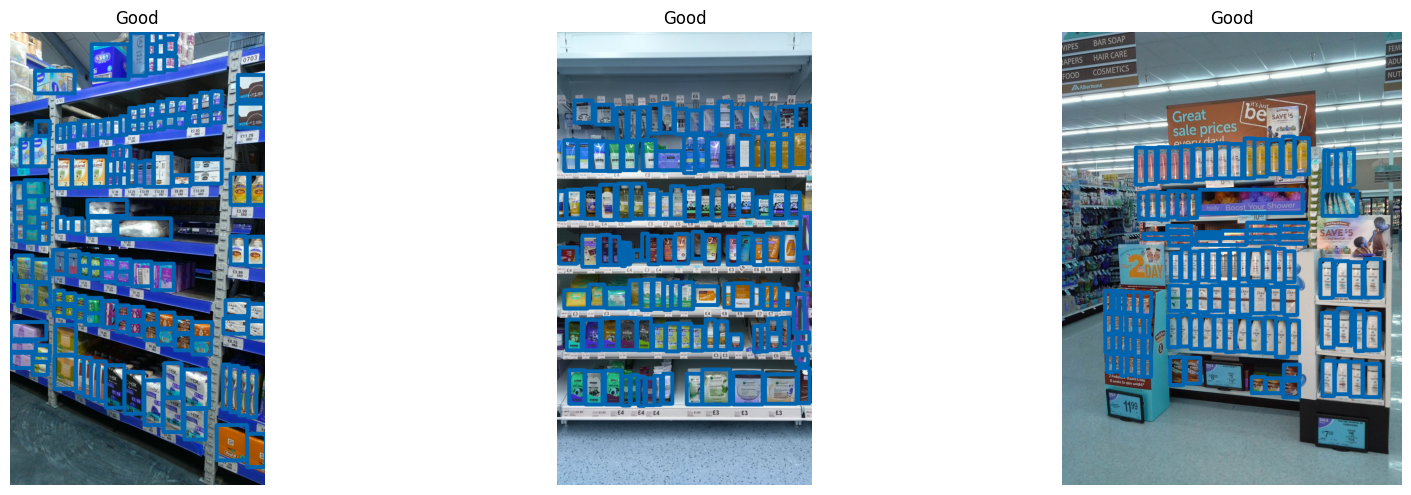

In [ ]:
visualize_sample(df_all_target_imgs[df_all_target_imgs.status == 'good'], 'Good')

/kaggle/input/target-sku/target_SKU/images/val/train_3144.jpg
/kaggle/input/target-sku/target_SKU/images/val/train_7452.jpg
/kaggle/input/target-sku/target_SKU/images/train/test_1910.jpg


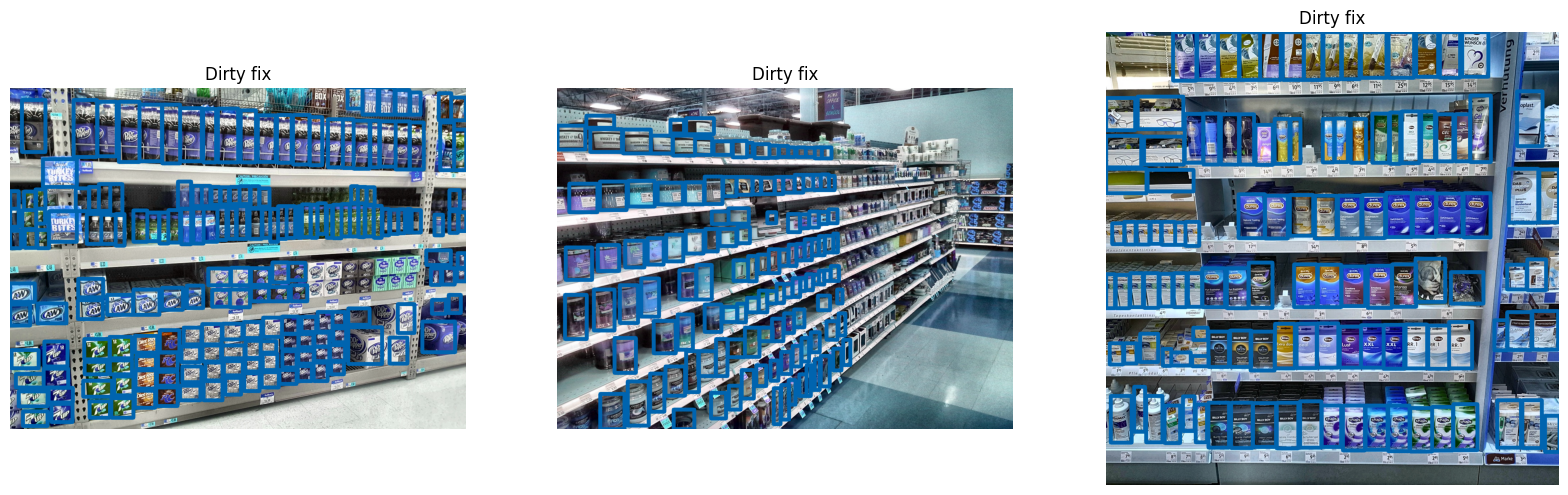

In [ ]:
visualize_sample(df_all_target_imgs[df_all_target_imgs.status == 'dirty_fixed'], 'Dirty fix')

/kaggle/input/target-sku/target_SKU/images/train/train_2975.jpg
/kaggle/input/target-sku/target_SKU/images/val/test_517.jpg
/kaggle/input/target-sku/target_SKU/images/train/train_6267.jpg


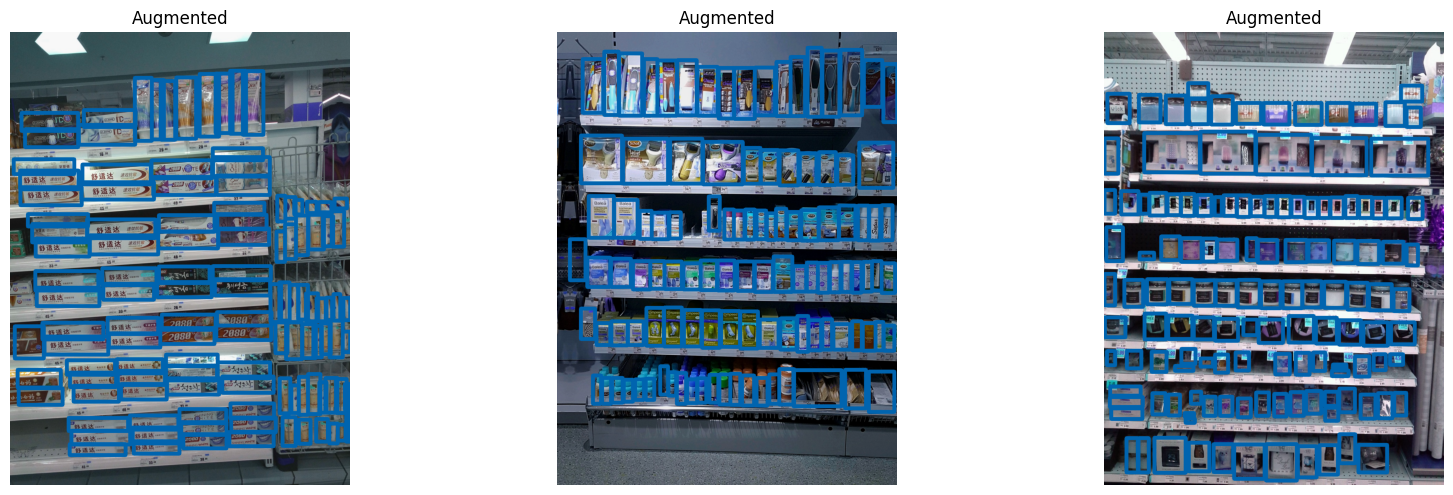

In [ ]:
visualize_sample(df_all_target_imgs[df_all_target_imgs.status == 'augmented'], 'Augmented')

# Train model

## Prepare environment

In [ ]:
# Remove ALL OpenCV + ultralytics conflicts
!pip uninstall opencv-python opencv-contrib-python opencv-python-headless opencv-contrib-python-headless ultralytics ray grpcio protobuf tensorboardx -y -q

# Install ultralytics FIRST (brings compatible OpenCV)
!pip install ultralytics==8.2.48 --no-deps
!pip install opencv-python==4.8.1.78 numpy==1.24.3 pillow==10.0.1

# Ray 2.8.1 + compatible stack (fixes _get_session error)
!pip install ray[data]==2.8.1 grpcio==1.59.0 protobuf==3.20.3


# Force restart kernel
import os

os.kill(os.getpid(), 9)

  Using cached ultralytics-8.2.48-py3-none-any.whl (793 kB)
  Using cached opencv_python-4.8.1.78-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.7 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ultralytics 8.2.48 requires ultralytics-thop>=2.0.0, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 MB 741.2 kB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 3.3 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.8 MB/s eta 0:00:00
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.51.1
    Uninstalling grpcio-1.51.1:
      Successfully uninstalled grpcio-1.51.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conf

## Train

In [ ]:
from pathlib import Path

TARGET_PATH = Path('/kaggle/input/target-sku')
TARGET_SKU_YAML = TARGET_PATH /'data.yaml'

In [ ]:
import torch
import os
from ultralytics import YOLO

torch.cuda.is_available()
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
model = YOLO("yolov8m.pt")  # load a pretrained YOLOv8n model

model.train(data=TARGET_SKU_YAML, batch=16, epochs=20)  # train the model

New https://pypi.org/project/ultralytics/8.4.12 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.48 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=/kaggle/input/target-sku/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show

Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/input/target-sku/target_SKU/labels/train... 3500 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3500/3500 [00:06<00:00, 553.07it/s]


train: WARNING ⚠️ Cache directory /kaggle/input/target-sku/target_SKU/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/target-sku/target_SKU/labels/val... 750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 750/750 [00:02<00:00, 316.53it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/target-sku/target_SKU/labels is not writeable, cache not saved.
Plotting labels to runs/detect/train7/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train7
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      15.6G      1.623     0.9318      1.128       2336        640: 100%|██████████| 219/219 [02:58<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.93it/s]

                   all        750     110070      0.819      0.723      0.807      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.5G      1.488     0.7309      1.054       3210        640: 100%|██████████| 219/219 [02:45<00:00,  1.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.95it/s]

                   all        750     110070      0.836      0.753      0.835      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      12.8G      1.469     0.7165      1.044       2814        640: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.96it/s]

                   all        750     110070      0.855      0.772      0.848      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      14.9G      1.447     0.7001      1.036       3476        640: 100%|██████████| 219/219 [02:43<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.89it/s]

                   all        750     110070      0.844      0.768      0.842        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      13.4G      1.444     0.6904      1.029       3478        640: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.96it/s]

                   all        750     110070      0.835      0.769      0.836      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      14.3G        1.4     0.6587      1.011       2921        640: 100%|██████████| 219/219 [02:44<00:00,  1.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.96it/s]

                   all        750     110070      0.865      0.794      0.868      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      15.7G      1.396     0.6563      1.012       2373        640: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.98it/s]

                   all        750     110070      0.863      0.792      0.872      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.5G      1.389     0.6437      1.005       2746        640: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.96it/s]

                   all        750     110070      0.877      0.812      0.886      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      13.3G      1.376     0.6343     0.9999       3260        640: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.93it/s]

                   all        750     110070      0.886      0.802      0.882      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      15.3G       1.36     0.6218      0.997       2896        640: 100%|██████████| 219/219 [02:44<00:00,  1.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.96it/s]

                   all        750     110070      0.885      0.816      0.889      0.551


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      11.6G      1.369     0.6283      1.029       1629        640: 100%|██████████| 219/219 [02:41<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.96it/s]


                   all        750     110070      0.882      0.818      0.887      0.547

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      11.2G       1.36     0.6161      1.023       1496        640: 100%|██████████| 219/219 [02:35<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.94it/s]

                   all        750     110070      0.874      0.805      0.885      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      11.9G      1.345     0.6034      1.022       1554        640: 100%|██████████| 219/219 [02:35<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.95it/s]

                   all        750     110070      0.885      0.823      0.892      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      12.5G      1.338     0.5935      1.019       1617        640: 100%|██████████| 219/219 [02:35<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.96it/s]

                   all        750     110070      0.889      0.823      0.896      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20        12G      1.331     0.5851       1.01       1817        640: 100%|██████████| 219/219 [02:35<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.97it/s]

                   all        750     110070      0.887      0.827      0.896       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20        13G      1.324     0.5801      1.007       1921        640: 100%|██████████| 219/219 [02:35<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.96it/s]

                   all        750     110070       0.89      0.825        0.9      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.6G      1.314     0.5687      1.004       1878        640: 100%|██████████| 219/219 [02:35<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.94it/s]

                   all        750     110070      0.876      0.817      0.889      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      11.5G      1.307     0.5634          1       1528        640: 100%|██████████| 219/219 [02:35<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.95it/s]

                   all        750     110070      0.865      0.784      0.872       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20        12G      1.298     0.5506     0.9979       1863        640: 100%|██████████| 219/219 [02:35<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.91it/s]

                   all        750     110070      0.896      0.826        0.9      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      11.6G      1.289     0.5438     0.9927       1992        640: 100%|██████████| 219/219 [02:35<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:12<00:00,  1.92it/s]

                   all        750     110070      0.887      0.817      0.894      0.563



20 epochs completed in 0.979 hours.
Optimizer stripped from runs/detect/train7/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train7/weights/best.pt, 52.0MB

Validating runs/detect/train7/weights/best.pt...
Ultralytics YOLOv8.2.48 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 24/24 [00:46<00:00,  1.94s/it]


                   all        750     110070      0.896      0.826        0.9      0.568
Speed: 0.4ms preprocess, 8.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train7


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c002cd52a40>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## Test validate

In [ ]:
metrics = model.val(data='/kaggle/input/target-sku/data.yaml', split='test')

print(metrics)


Ultralytics YOLOv8.2.48 🚀 Python-3.10.10 torch-2.0.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 218 layers, 25840339 parameters, 0 gradients


100%|██████████| 755k/755k [00:00<00:00, 19.9MB/s]
val: Scanning /kaggle/input/target-sku/target_SKU/labels/test... 750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 750/750 [00:03<00:00, 194.62it/s]


val: WARNING ⚠️ Cache directory /kaggle/input/target-sku/target_SKU/labels is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   4%|▍         | 2/47 [00:08<03:38,  4.86s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   6%|▋         | 3/47 [00:15<04:07,  5.63s/it]

WARNING ⚠️ NMS time limit 2.800s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 47/47 [00:42<00:00,  1.10it/s]


                   all        750     109851      0.906      0.834      0.905      0.588


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Speed: 0.4ms preprocess, 11.5ms inference, 0.0ms loss, 10.8ms postprocess per image
Results saved to runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79daa8168cd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.0

## Visualize results

In [ ]:
TEST_IMAGES = TARGET_PATH / "target_SKU" / "images" / "test"

In [ ]:
import random
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from pathlib import Path
from ultralytics import YOLO

def visualize_sample_comparison(df: pd.DataFrame, model_path: str):
    """
    Visualize: Original | Ground Truth (Green) | Predictions (Red) 
    Random 3 samples
    """
    model = YOLO(model_path)  # Your trained model
    counter = 1
    plt.figure(figsize=(25, 20), facecolor='white')

    for idx in random.sample(range(0, len(df)), 3):
        # File paths
        filename_image = str(TARGET_IMAGES_PATH / df.iloc[idx]['target_sku_sample'] / df.iloc[idx]['img_name'])
        filename_label = str((TARGET_LABELS_PATH / df.iloc[idx]['target_sku_sample'] / df.iloc[idx]['img_name']).with_suffix('.txt'))

        print(f"Processing: {filename_image}")
        
        # Load original image
        im = cv2.imread(filename_image)
        im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im_size = im.shape[:2]
        
        # 1. GROUND TRUTH IMAGE (Green boxes)
        gt_img = im_rgb.copy()
        if Path(filename_label).exists():
            data = pd.read_csv(filename_label, header=None, delimiter=' ')
            for _, bbox in data.iterrows():
                cls, xc, yc, w, h = bbox
                xmin = (xc - w/2) * im_size[1]
                ymin = (yc - h/2) * im_size[0]
                xmax = (xc + w/2) * im_size[1]
                ymax = (yc + h/2) * im_size[0]
                
                cv2.rectangle(gt_img, 
                            (int(xmin), int(ymin)), 
                            (int(xmax), int(ymax)), 
                            (0, 255, 0), 8)  # Thick GREEN boxes
        
        # 2. PREDICTION IMAGE (Red boxes from your model)
        pred_results = model.predict(filename_image, save=False, verbose=False)
        pred_img = pred_results[0].plot()  # YOLO draws red boxes automatically
        
        # 3. ORIGINAL IMAGE (no boxes)
        orig_img = im_rgb.copy()
        
        # Plot 3 columns: Original | GT | Predictions
        ax1 = plt.subplot(3, 3, counter)
        plt.imshow(orig_img)
        plt.title(f"Original #{counter}", fontsize=14, fontweight='bold')
        plt.axis("off")
        
        ax2 = plt.subplot(3, 3, counter+1)
        plt.imshow(gt_img)
        plt.title(f"Ground Truth (Green) #{counter}", fontsize=14, fontweight='bold')
        plt.axis("off")
        
        ax3 = plt.subplot(3, 3, counter+2)
        plt.imshow(pred_img)
        plt.title(f"Predictions (Red) #{counter}", fontsize=14, fontweight='bold')
        plt.axis("off")
        
        counter += 3
    
    plt.suptitle(None, fontsize=20, fontweight='bold')
    plt.tight_layout()
    plt.show()
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')

In [ ]:
df_all_target_imgs = pd.read_csv(str(TARGET_PATH / 'img_logs.csv'))
df_test_target_imgs = df_all_target_imgs[df_all_target_imgs.target_sku_sample == 'test']

Processing: /kaggle/input/target-sku/target_SKU/images/test/train_4851.jpg
Processing: /kaggle/input/target-sku/target_SKU/images/test/test_1605.jpg
Processing: /kaggle/input/target-sku/target_SKU/images/test/train_4953.jpg


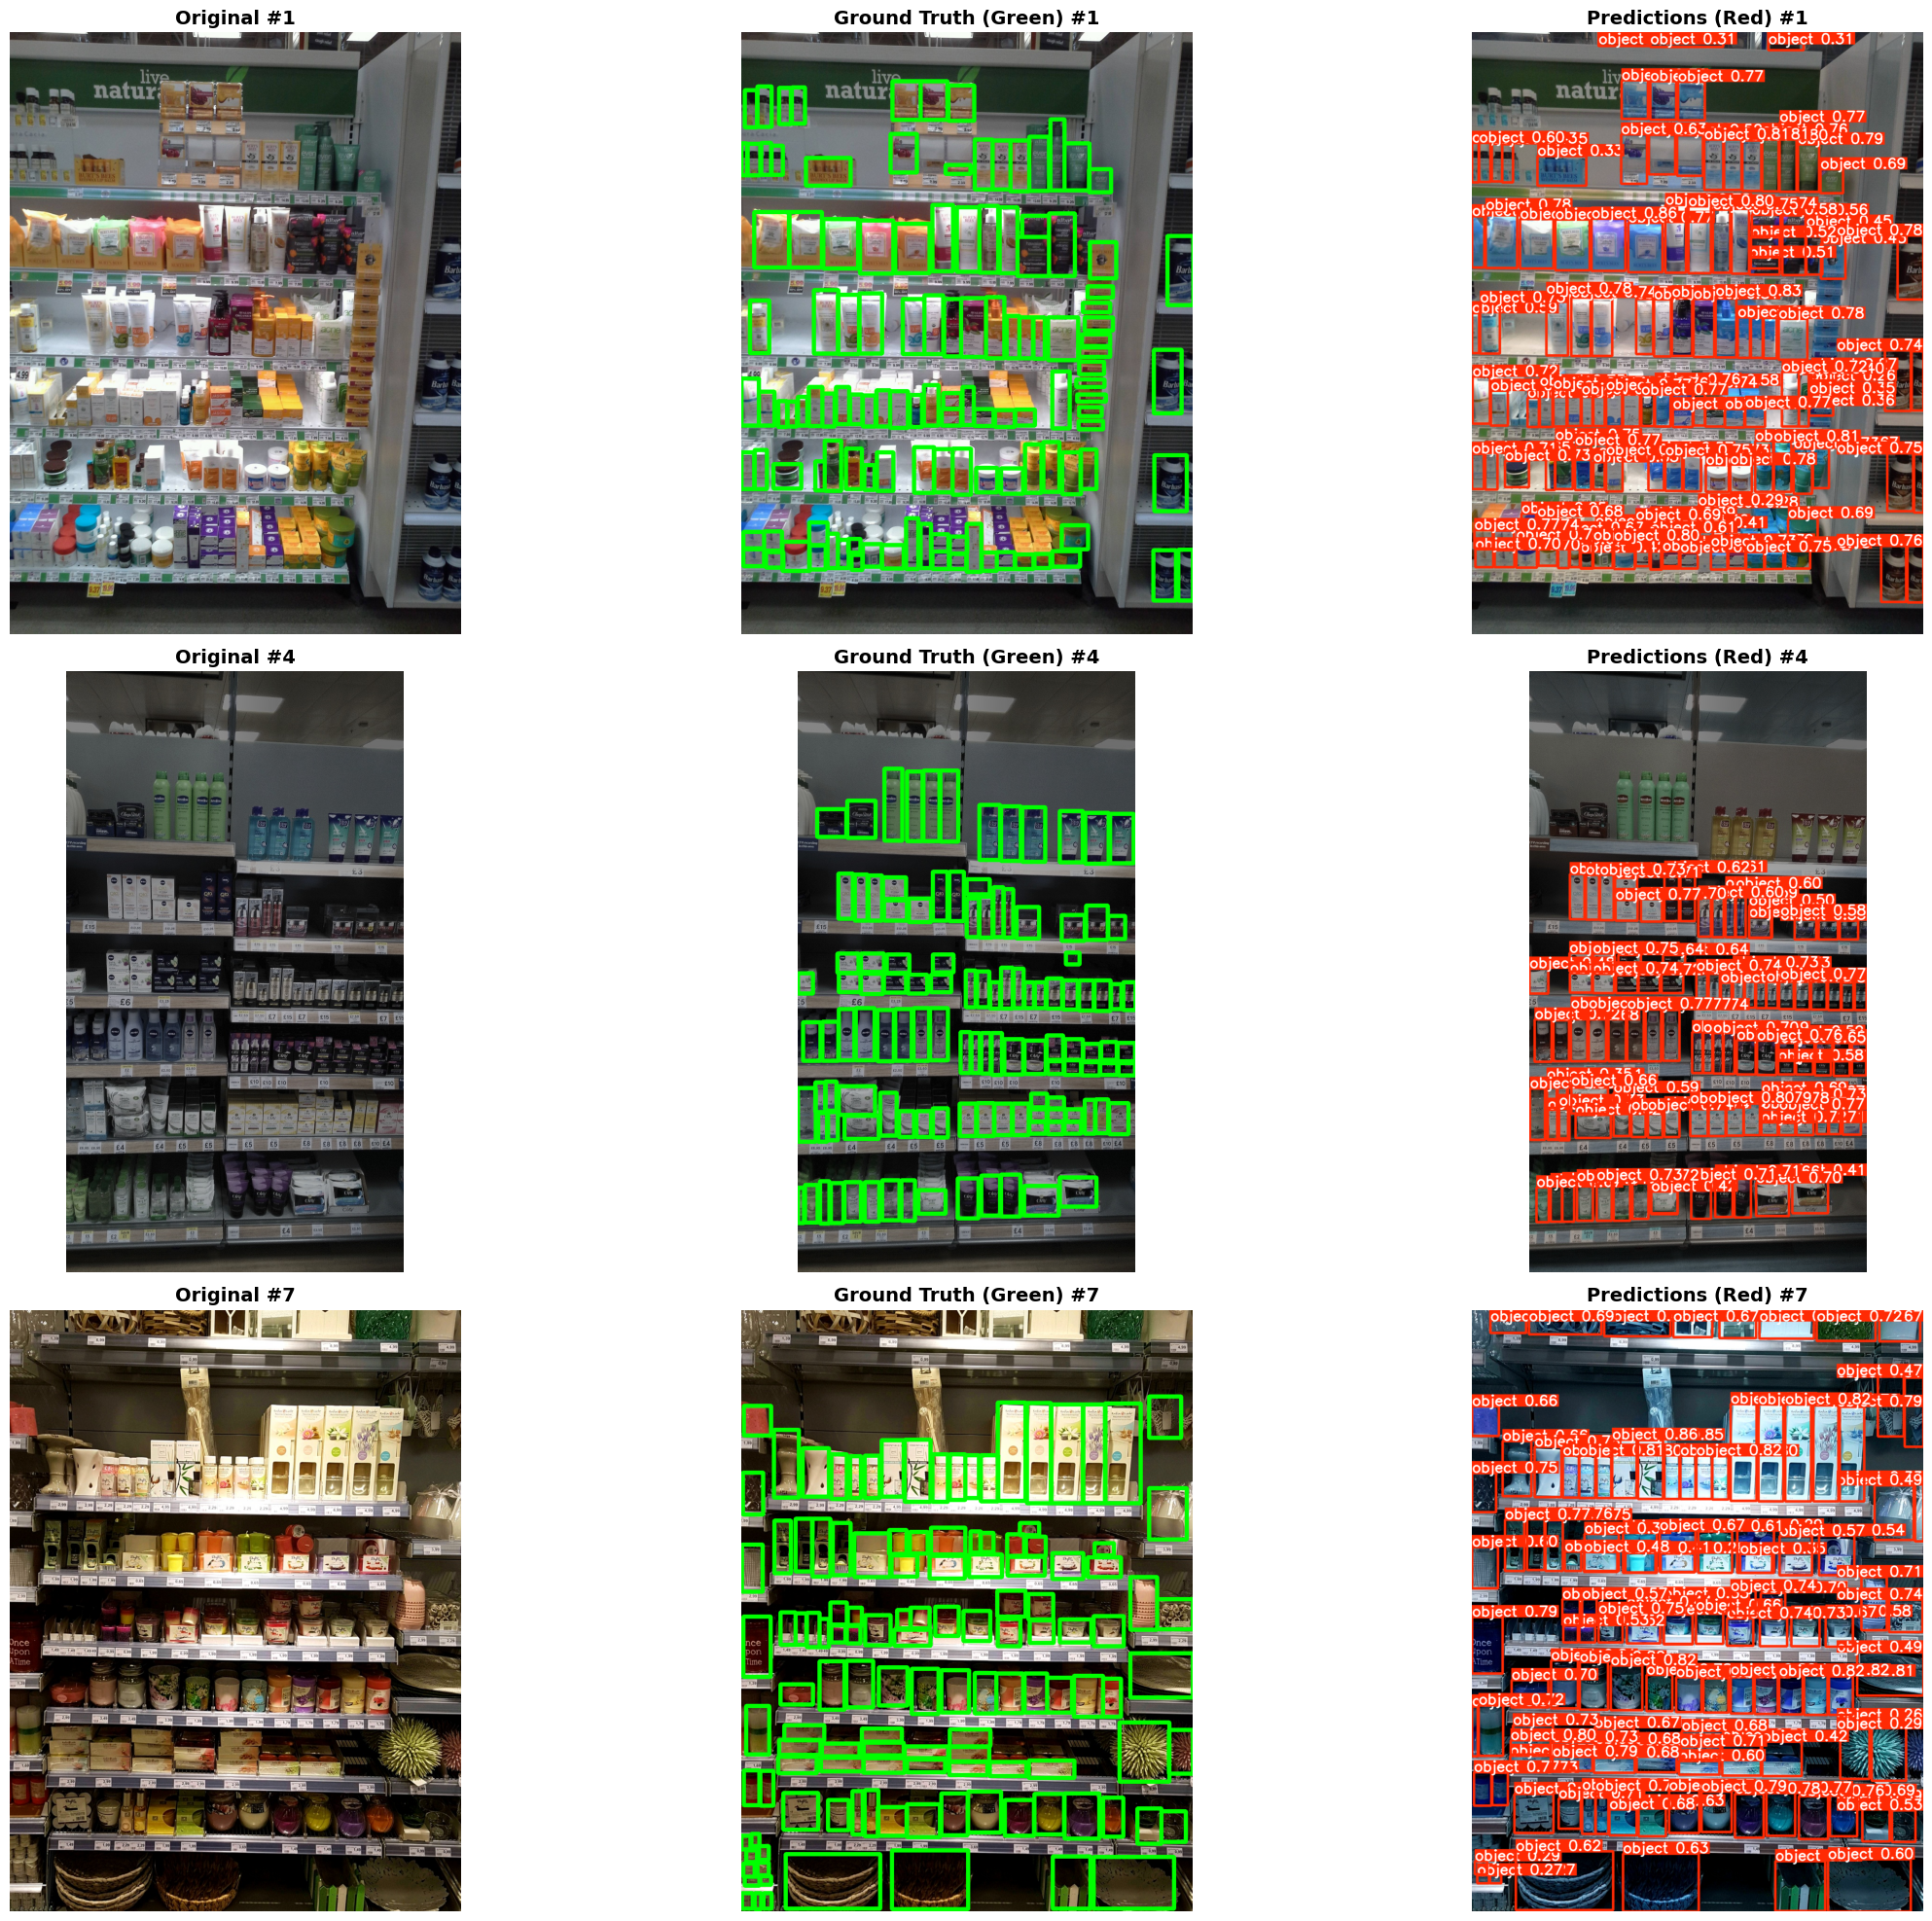

<Figure size 640x480 with 0 Axes>

In [ ]:
model = "/kaggle/working/runs/detect/train7/weights/best.pt"

visualize_sample_comparison(df_test_target_imgs, model)